<a href="https://colab.research.google.com/github/meinicharat/Automated-CISA-KEV-Risk-Analytics/blob/main/Automated_CISA_KEV_Risk_Analytics_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [230]:
!pip -q install pandas sqlalchemy sqlite-utils altair python-dateutil


In [231]:
import sys, os, math
import pandas as pd
import sqlalchemy as sa
import sqlite3
import altair as alt
import numpy as np

In [232]:
os.makedirs("exports", exist_ok=True)

In [233]:
print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)
print("SQLAlchemy:", sa.__version__)
print("sqlite3 (client):", sqlite3.sqlite_version)
print("Altair:", alt.__version__)

Python: 3.12.12
pandas: 2.2.2
SQLAlchemy: 2.0.45
sqlite3 (client): 3.37.2
Altair: 5.5.0


In [234]:
try:
    con = sqlite3.connect(":memory:")
    cur = con.cursor()
    cur.execute("PRAGMA compile_options;")
    opts = [r[0] for r in cur.fetchall()]
    con.close()
    print("SQLite compile options:")
    for o in opts[:10]:
        print(" -", o)
except Exception as e:
    print("ตรวจ PRAGMA ไม่สำเร็จ:", e)

print("\n[SUMMARY] Environment is ready. Created folder: ./exports")

SQLite compile options:
 - ATOMIC_INTRINSICS=1
 - COMPILER=gcc-11.4.0
 - DEFAULT_AUTOVACUUM
 - DEFAULT_CACHE_SIZE=-2000
 - DEFAULT_FILE_FORMAT=4
 - DEFAULT_JOURNAL_SIZE_LIMIT=-1
 - DEFAULT_MMAP_SIZE=0
 - DEFAULT_PAGE_SIZE=4096
 - DEFAULT_PCACHE_INITSZ=20
 - DEFAULT_RECURSIVE_TRIGGERS

[SUMMARY] Environment is ready. Created folder: ./exports


In [235]:
url = "https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv"
df_raw = pd.read_csv(url, low_memory=False)

In [236]:
print("[RAW] Shape:", df_raw.shape)
print("[RAW] Total columns:", len(df_raw.columns))
print("[RAW] Columns (all):")
print(" | ".join(df_raw.columns.tolist()))

[RAW] Shape: (1488, 11)
[RAW] Total columns: 11
[RAW] Columns (all):
cveID | vendorProject | product | vulnerabilityName | dateAdded | shortDescription | requiredAction | dueDate | knownRansomwareCampaignUse | notes | cwes


In [237]:
rename_map = {
    "cveID": "cve_id",
    "vendorProject": "vendor",
    "vulnerabilityName": "vuln_name",
    "dateAdded": "date_added",
    "shortDescription": "short_desc",
    "requiredAction": "required_action",
    "dueDate": "due_date",
    "knownRansomwareCampaignUse": "known_ransomware_use",
    "cwes": "cwe",
}

raw_cols = set(df_raw.columns)
present_to_rename = {k: v for k, v in rename_map.items() if k in raw_cols}
df = df_raw.rename(columns=present_to_rename)

In [238]:
for col in ["date_added", "due_date"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce", utc=True)

In [239]:
for col in ["cve_id", "vendor", "product", "vuln_name"]:
    if col in df.columns:
        df[col] = (
            df[col].astype(str)
                  .str.strip()
                  .str.replace(r"\s+", " ", regex=True)
                  )

In [240]:
for rc in ["cve_id", "date_added"]:
    if rc not in df.columns:
        df[rc] = np.nan
before_dropna = len(df)
df = df.dropna(subset=["cve_id", "date_added"])
after_dropna = len(df)

In [241]:
before_dedup = len(df)
df = df.drop_duplicates(subset=["cve_id", "vendor", "product", "date_added"]).reset_index(drop=True)
after_dedup = len(df)

In [242]:
#เอาไว้ดูรายเดือนได้
df["month_key"] = df["date_added"].dt.strftime("%Y-%m")

In [243]:
date_min = df["date_added"].min()
date_max = df["date_added"].max()
n_vendor = df["vendor"].nunique() if "vendor" in df.columns else None

In [244]:
print("[CLEAN] Rows after dropna:", after_dropna, f"(removed {before_dropna - after_dropna})")
print("[CLEAN] Rows after dedupe:", after_dedup, f"(removed {before_dedup - after_dedup})")
print(f"[CLEAN] Date range: {date_min} -> {date_max}")
print(f"[CLEAN] Unique vendors: {n_vendor}")
print("\nSample rows:")
print(df[["cve_id","vendor","product","date_added","month_key"]].head(8).to_string(index=False))

[CLEAN] Rows after dropna: 1488 (removed 0)
[CLEAN] Rows after dedupe: 1488 (removed 0)
[CLEAN] Date range: 2021-11-03 00:00:00+00:00 -> 2026-01-13 00:00:00+00:00
[CLEAN] Unique vendors: 245

Sample rows:
        cve_id                           vendor                    product                date_added month_key
CVE-2026-20805                        Microsoft                    Windows 2026-01-13 00:00:00+00:00   2026-01
 CVE-2025-8110                             Gogs                       Gogs 2026-01-12 00:00:00+00:00   2026-01
 CVE-2009-0556                        Microsoft                     Office 2026-01-07 00:00:00+00:00   2026-01
CVE-2025-37164 Hewlett Packard Enterprise (HPE)                    OneView 2026-01-07 00:00:00+00:00   2026-01
CVE-2025-14847                          MongoDB MongoDB and MongoDB Server 2025-12-29 00:00:00+00:00   2025-12
CVE-2023-52163                         Digiever                DS-2105 Pro 2025-12-22 00:00:00+00:00   2025-12
CVE-2025-14733    

In [147]:
print(df.shape)

(1488, 12)


In [148]:
#ตรวจหา missing value
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
print("Missing Values (%):")
print(missing_pct.round(2).to_string())
print("="*80)

Missing Values (%):
cwe                     11.16
cve_id                   0.00
product                  0.00
vendor                   0.00
vuln_name                0.00
date_added               0.00
required_action          0.00
short_desc               0.00
due_date                 0.00
known_ransomware_use     0.00
notes                    0.00
month_key                0.00


In [149]:
df[df["cwe"].isna()]

,cve_id,vendor,product,vuln_name,date_added,short_desc,required_action,due_date,known_ransomware_use,notes,cwe,month_key
14,CVE-2025-14174,Google,Chromium,Google Chromium Out of Bounds Memory Access Vu...,2025-12-12 00:00:00+00:00,Google Chromium contains an out of bounds memo...,"Apply mitigations per vendor instructions, fol...",2026-01-02 00:00:00+00:00,Unknown,https://chromereleases.googleblog.com/2025/12/...,NaN,2025-12
20,CVE-2025-55182,Meta,React Server Components,Meta React Server Components Remote Code Execu...,2025-12-05 00:00:00+00:00,Meta React Server Components contains a remote...,"Apply mitigations per vendor instructions, fol...",2025-12-12 00:00:00+00:00,Known,Check for signs of potential compromise on all...,NaN,2025-12
22,CVE-2025-48633,Android,Framework,Android Framework Information Disclosure Vulne...,2025-12-02 00:00:00+00:00,Android Framework contains an unspecified vuln...,"Apply mitigations per vendor instructions, fol...",2025-12-23 00:00:00+00:00,Unknown,https://source.android.com/docs/security/bulle...,NaN,2025-12
23,CVE-2025-48572,Android,Framework,Android Framework Privilege Escalation Vulnera...,2025-12-02 00:00:00+00:00,Android Framework contains an unspecified vuln...,"Apply mitigations per vendor instructions, fol...",2025-12-23 00:00:00+00:00,Unknown,https://source.android.com/docs/security/bulle...,NaN,2025-12
42,CVE-2022-48503,Apple,Multiple Products,Apple Multiple Products Unspecified Vulnerability,2025-10-20 00:00:00+00:00,"Apple macOS, iOS, tvOS, Safari, and watchOS co...","Apply mitigations per vendor instructions, fol...",2025-11-10 00:00:00+00:00,Unknown,https://support.apple.com/en-us/HT213340 ; htt...,NaN,2025-10
...,...,...,...,...,...,...,...,...,...,...,...,...
1440,CVE-2019-16256,SIMalliance,Toolbox Browser,SIMalliance Toolbox Browser Command Injection ...,2021-11-03 00:00:00+00:00,SIMalliance Toolbox Browser contains an comman...,Apply updates per vendor instructions.,2022-05-03 00:00:00+00:00,Unknown,https://nvd.nist.gov/vuln/detail/CVE-2019-16256,NaN,2021-11
1461,CVE-2020-8467,Trend Micro,Apex One and OfficeScan,Trend Micro Apex One and OfficeScan Remote Cod...,2021-11-03 00:00:00+00:00,Trend Micro Apex One and OfficeScan contain an...,Apply updates per vendor instructions.,2022-05-03 00:00:00+00:00,Unknown,https://nvd.nist.gov/vuln/detail/CVE-2020-8467,NaN,2021-11
1463,CVE-2020-24557,Trend Micro,"Apex One, OfficeScan, and Worry-Free Business ...",Trend Micro Multiple Products Improper Access ...,2021-11-03 00:00:00+00:00,"Trend Micro Apex One, OfficeScan, and Worry-Fr...",Apply updates per vendor instructions.,2022-05-03 00:00:00+00:00,Unknown,https://nvd.nist.gov/vuln/detail/CVE-2020-24557,NaN,2021-11
1464,CVE-2020-8599,Trend Micro,Apex One and OfficeScan,Trend Micro Apex One and OfficeScan Authentica...,2021-11-03 00:00:00+00:00,Trend Micro Apex One and OfficeScan server con...,Apply updates per vendor instructions.,2022-05-03 00:00:00+00:00,Unknown,https://nvd.nist.gov/vuln/detail/CVE-2020-8599,NaN,2021-11


In [150]:
df["cwe"] = df["cwe"].fillna("Unknown")

In [151]:
df["cwe"].isna().sum()

np.int64(0)

In [152]:
#EDA
import matplotlib.pyplot as plt

In [153]:
#ตรวจ duplicates
dupes = df.duplicated(subset=["cve_id", "vendor", "product", "date_added"]).sum()
print(f"Duplicate rows (by cve_id + vendor + product + date_added): {dupes}")

Duplicate rows (by cve_id + vendor + product + date_added): 0


In [154]:
#trend ช่องโหว่รายเดือน
monthly_trend = df.groupby("month_key")["cve_id"].nunique().reset_index()
monthly_trend.rename(columns={"cve_id": "vuln_count"}, inplace=True)
print("Monthly Trend (Top 10 rows):")
print(monthly_trend.head(10).to_string(index=False))

Monthly Trend (Top 10 rows):
month_key  vuln_count
  2021-11         291
  2021-12          20
  2022-01          40
  2022-02          32
  2022-03         226
  2022-04          45
  2022-05          83
  2022-06          48
  2022-07           3
  2022-08          23


In [155]:
#top 10 vendors
if "vendor" in df.columns:
    top_vendors = df["vendor"].value_counts().head(10).reset_index()
    top_vendors.columns = ["vendor", "vuln_count"]

    print("Top 10 Vendors:")
    print(top_vendors.to_string(index=False))
else:
    print("Column 'vendor' not found")

Top 10 Vendors:
   vendor  vuln_count
Microsoft         352
    Apple          86
    Cisco          82
    Adobe          76
   Google          67
   Oracle          42
   Apache          38
   Ivanti          30
   VMware          26
   D-Link          25


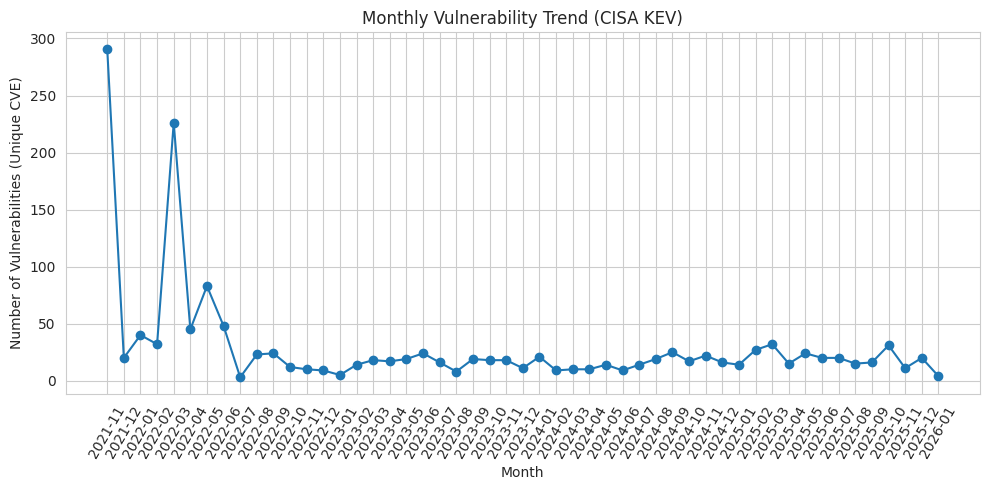

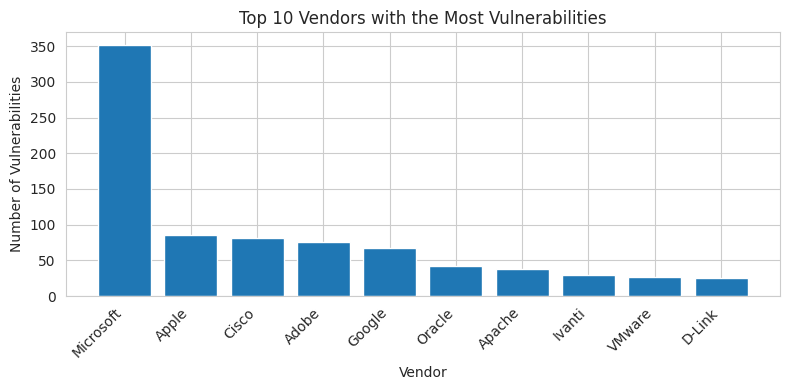

In [156]:
#visualization
plt.figure(figsize=(10,5))
plt.plot(monthly_trend["month_key"], monthly_trend["vuln_count"], marker="o")
plt.xticks(rotation=60)
plt.title("Monthly Vulnerability Trend (CISA KEV)")
plt.xlabel("Month")
plt.ylabel("Number of Vulnerabilities (Unique CVE)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.bar(top_vendors["vendor"], top_vendors["vuln_count"])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Vendors with the Most Vulnerabilities")
plt.ylabel("Number of Vulnerabilities")
plt.xlabel("Vendor")
plt.tight_layout()
plt.show()

In [157]:
import os
import pandas as pd
import sqlalchemy as sa
from sqlalchemy import create_engine, text

db_path = "risk.db"
engine = create_engine(f"sqlite:///{db_path}", future=True)

In [158]:
#เตรียมdf
df_to_db = df.copy()

for col in ["date_added", "due_date"]:
    if col in df_to_db.columns:
        df_to_db[col] = pd.to_datetime(df_to_db[col], errors="coerce", utc=True).dt.strftime("%Y-%m-%d")

In [159]:
#เอาdfเก็บในsqlite
df_to_db.to_sql("kev_vulns", con=engine, if_exists="replace", index=False)

1488

In [160]:
with engine.begin() as conn:
    conn.exec_driver_sql("CREATE INDEX IF NOT EXISTS idx_kev_date ON kev_vulns(date_added);")
    if "vendor" in df_to_db.columns:
        conn.exec_driver_sql("CREATE INDEX IF NOT EXISTS idx_kev_vendor ON kev_vulns(vendor);")

In [161]:
#ตรวจ risk.db
with engine.connect() as conn:
    rowcount = conn.execute(text("SELECT COUNT(*) FROM kev_vulns")).scalar_one()
    sample = pd.read_sql(text("""
        SELECT cve_id, vendor, product, date_added
        FROM kev_vulns
        ORDER BY date_added DESC
        LIMIT 5;
    """), conn)


In [162]:
#สรุปผล
print(f"เขียนตาราง kev_vulns ลง db '{db_path}' เรียบร้อย: {rowcount:,} แถว")
print("ตัวอย่าง 5 แถวล่าสุด:")
print(sample.to_string(index=False))
print("\n[SUMMARY] DB file exists:", os.path.exists(db_path), "| Size (bytes):", os.path.getsize(db_path) if os.path.exists(db_path) else 0)


เขียนตาราง kev_vulns ลง db 'risk.db' เรียบร้อย: 1,488 แถว
ตัวอย่าง 5 แถวล่าสุด:
        cve_id                           vendor                    product date_added
CVE-2026-20805                        Microsoft                    Windows 2026-01-13
 CVE-2025-8110                             Gogs                       Gogs 2026-01-12
CVE-2025-37164 Hewlett Packard Enterprise (HPE)                    OneView 2026-01-07
 CVE-2009-0556                        Microsoft                     Office 2026-01-07
CVE-2025-14847                          MongoDB MongoDB and MongoDB Server 2025-12-29

[SUMMARY] DB file exists: True | Size (bytes): 929792


In [245]:
import os
import pandas as pd
import sqlalchemy as sa
from sqlalchemy import create_engine, text

In [246]:
#query monthly trend + rolling 6 m
q_trend_rolling = """
WITH m AS (
  SELECT
    month_key,
    COUNT(DISTINCT cve_id) AS vuln_count
  FROM kev_vulns
  WHERE month_key IS NOT NULL
  GROUP BY month_key
)
SELECT
  month_key,
  vuln_count,
  SUM(vuln_count) OVER (
    ORDER BY month_key
    ROWS BETWEEN 5 PRECEDING AND CURRENT ROW
  ) AS rolling_6m
FROM m
ORDER BY month_key;
"""

In [247]:
#query monthly trend with vendor
q_trend_by_vendor = """
WITH m AS (
  SELECT
    month_key,
    vendor,
    COUNT(DISTINCT cve_id) AS vuln_count
  FROM kev_vulns
  WHERE month_key IS NOT NULL
  GROUP BY month_key, vendor
)
SELECT * FROM m
ORDER BY month_key, vendor;
"""

In [248]:
#Top vendors in the last 12 m
q_top_vendor_12m = """
WITH bounds AS (
  SELECT
    date(strftime('%Y-%m-01', MAX(date_added))) AS max_month_start,
    date(strftime('%Y-%m-01', MAX(date_added)), '-11 months') AS cutoff_month_start
  FROM kev_vulns
),
filtered AS (
  SELECT k.vendor, k.cve_id
  FROM kev_vulns k
  JOIN bounds b
    ON date(k.date_added) >= b.cutoff_month_start
)
SELECT
  vendor,
  COUNT(DISTINCT cve_id) AS cve_count_12m
FROM filtered
GROUP BY vendor
ORDER BY cve_count_12m DESC
LIMIT 10;
"""

In [249]:
#query top 5 vendors each month
q_top5 = """
WITH m AS (
  SELECT month_key, vendor, COUNT(DISTINCT cve_id) AS vuln_count
  FROM kev_vulns
  WHERE month_key IS NOT NULL
  GROUP BY month_key, vendor
),
r AS (
  SELECT
    m.*,
    ROW_NUMBER() OVER (PARTITION BY month_key ORDER BY vuln_count DESC, vendor) AS rk
  FROM m
)
SELECT month_key, vendor, vuln_count
FROM r
WHERE rk <= 5
ORDER BY month_key, rk;
"""

In [250]:
#run quries and preview results
with engine.connect() as conn:
    df_trend = pd.read_sql(text(q_trend_rolling), conn)
    df_top_vendor_12m = pd.read_sql(text(q_top_vendor_12m), conn)
    df_trend_vendor = pd.read_sql(text(q_trend_by_vendor), conn)
    df_top5 = pd.read_sql(text(q_top5), conn)

print("Ran SQL queries successfully.")
print("\n Monthly trend + rolling 6M (head):")
print(df_trend.head(10).to_string(index=False))

print("\n Top vendors (last 12 months):")
print(df_top_vendor_12m.to_string(index=False))

print("\n Trend by vendor (head):")
print(df_trend_vendor.head(10).to_string(index=False))

print("\n Top 5 vendors each month :")
print(df_top5.to_string(index=False))

Ran SQL queries successfully.

 Monthly trend + rolling 6M (head):
month_key  vuln_count  rolling_6m
  2021-11         291         291
  2021-12          20         311
  2022-01          40         351
  2022-02          32         383
  2022-03         226         609
  2022-04          45         654
  2022-05          83         446
  2022-06          48         474
  2022-07           3         437
  2022-08          23         428

 Top vendors (last 12 months):
   vendor  cve_count_12m
Microsoft             38
    Apple              8
    Cisco              8
 Fortinet              7
   Google              7
    Linux              7
   Ivanti              6
   Citrix              5
   D-Link              5
 Gladinet              4

 Trend by vendor (head):
month_key    vendor  vuln_count
  2021-11 Accellion           4
  2021-11     Adobe           5
  2021-11   Amcrest           1
  2021-11   Android           2
  2021-11    Apache           9
  2021-11     Apple          23
  

In [251]:
from google.colab import userdata
NVD_API_KEY = userdata.get('NVD_API_KEY')
print(f"API Key Loaded: {NVD_API_KEY[:5]}...")

API Key Loaded: d843f...


In [252]:
import requests
import json

url = "https://services.nvd.nist.gov/rest/json/cves/2.0?cveId=CVE-2021-44228"
response = requests.get(url)
data = response.json()

#vulnerabilities -> ตัวที่ 0 -> cve -> metrics
#เก็บใส่ my_score
my_score = data['vulnerabilities'][0]['cve']['metrics']

#printเฉพาะส่วนคะแนน
print(json.dumps(my_score, indent=4))

{
    "cvssMetricV31": [
        {
            "source": "nvd@nist.gov",
            "type": "Primary",
            "cvssData": {
                "version": "3.1",
                "vectorString": "CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:H/I:H/A:H",
                "baseScore": 10.0,
                "baseSeverity": "CRITICAL",
                "attackVector": "NETWORK",
                "attackComplexity": "LOW",
                "privilegesRequired": "NONE",
                "userInteraction": "NONE",
                "scope": "CHANGED",
                "confidentialityImpact": "HIGH",
                "integrityImpact": "HIGH",
                "availabilityImpact": "HIGH"
            },
            "exploitabilityScore": 3.9,
            "impactScore": 6.0
        },
        {
            "source": "134c704f-9b21-4f2e-91b3-4a467353bcc0",
            "type": "Secondary",
            "cvssData": {
                "version": "3.1",
                "vectorString": "CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C

In [ ]:
#ดึงคะแนน CVSS จริงจาก NVD API
import requests, time, os, pandas as pd

NVD_BASE = "https://services.nvd.nist.gov/rest/json/cves/2.0"

#True = Simulation Mode, False = Live Mode
use_simulation = False

def fetch_nvd_cvss_all(cve_ids, pause_with_key=0.6, pause_no_key=6.0):
    mapping = {}
    total = len(cve_ids)
    headers = {"apiKey": NVD_API_KEY} if NVD_API_KEY else {}

    print(f"[NVD] Start fetching {total} CVEs(One by One)")

    for index, cve in enumerate(cve_ids):
        try:
            params = {"cveId": cve} #ใช้ cve ยิงไปที่ API
            r = requests.get(NVD_BASE, params=params, headers=headers, timeout=10)

            if r.status_code in (403, 429, 502, 503):
                print(f"[WARN] Busy at {cve}. Skipping...")
                time.sleep(5)
                continue

            if r.status_code == 200:
                data = r.json()
                for item in data.get("vulnerabilities", []):
                    if item["cve"]["id"] == cve:
                        metrics = item["cve"].get("metrics", {})
                        cvss = severity = None

                        #ดึงคะแนน (V3.1 > V3.0 > V2.0)
                        for key in ("cvssMetricV31", "cvssMetricV30", "cvssMetricV2"):
                            if key in metrics:
                                m = metrics[key][0].get("cvssData", {})
                                cvss = m.get("baseScore")
                                severity = m.get("baseSeverity")
                                break

                        mapping[cve] = {"cvss": cvss, "severity": severity}
                        break
                print(f"[{index+1}/{total}] Fetched: {cve}")
            else:
                print(f"[{index+1}/{total}] Failed: {cve}")

        except Exception as e:
            print(f"[ERROR] {cve}: {e}")

        time.sleep(pause_with_key if NVD_API_KEY else pause_no_key)

    return mapping

df_expo = df.copy()

list_of_cves = df_expo['cve_id'].unique().tolist()

print("-" * 30)
if use_simulation:
    print("⚠️SIMULATION MODE ACTIVATED")
    #CREATE SIMULATED DATA
    simulated_scores = np.random.normal(loc=7.5, scale=1.2, size=len(df_expo))
    simulated_scores = np.clip(simulated_scores, 1.0, 10.0)

    df_expo["cvss"] = simulated_scores
    df_expo["severity"] = "HIGH (Simulated)"
    print(f"Generated scores for {len(df_expo)} rows.")

else:
    print("LIVE MODE ACTIVATED")
    nvd_results = fetch_nvd_cvss_all(list_of_cves)

    df_expo["cvss"] = df_expo["cve_id"].map(lambda x: nvd_results.get(x, {}).get("cvss"))
    df_expo["severity"] = df_expo["cve_id"].map(lambda x: nvd_results.get(x, {}).get("severity"))

#Fill NA
df_expo["cvss"] = df_expo["cvss"].fillna(7.5)
print("-" * 30)
print("Preview Data:")
print(df_expo[['cve_id', 'cvss']].head())

------------------------------
LIVE MODE ACTIVATED
[NVD] Start fetching 1488 CVEs(One by One)
[1/1488] Fetched: CVE-2026-20805
[2/1488] Fetched: CVE-2025-8110
[3/1488] Fetched: CVE-2009-0556
[4/1488] Fetched: CVE-2025-37164
[5/1488] Fetched: CVE-2025-14847
[6/1488] Fetched: CVE-2023-52163
[7/1488] Fetched: CVE-2025-14733
[8/1488] Fetched: CVE-2025-59374
[9/1488] Fetched: CVE-2025-40602
[10/1488] Fetched: CVE-2025-20393
[11/1488] Fetched: CVE-2025-59718
[12/1488] Fetched: CVE-2025-14611
[13/1488] Fetched: CVE-2025-43529
[14/1488] Fetched: CVE-2018-4063
[15/1488] Fetched: CVE-2025-14174
[16/1488] Fetched: CVE-2025-58360
[17/1488] Fetched: CVE-2025-6218
[18/1488] Fetched: CVE-2025-62221
[19/1488] Fetched: CVE-2022-37055
[20/1488] Fetched: CVE-2025-66644
[21/1488] Fetched: CVE-2025-55182
[22/1488] Fetched: CVE-2021-26828
[23/1488] Fetched: CVE-2025-48633
[24/1488] Fetched: CVE-2025-48572
[25/1488] Fetched: CVE-2021-26829
[26/1488] Fetched: CVE-2025-61757
[27/1488] Fetched: CVE-2025-13223
[

In [ ]:
#คำนวณอายุช่องโหว่
as_of = pd.Timestamp.now(tz='UTC')
df_expo["age_days"] = (as_of - df_expo["date_added"]).dt.days

In [ ]:
#คำนวณ decay factor
HALF_LIFE = 180.0
df_expo["decay"] = np.power(0.5, df_expo["age_days"] / HALF_LIFE)

In [ ]:
real_count = len(nvd_results)
total_rows = len(df_expo)

print(f"จำนวนที่ดึงสำเร็จ: {real_count}")
print(f"จำนวนที่ต้องจำลอง: {total_rows - real_count}")

In [ ]:
print("[CVSS coverage] describe():")
print(df_expo["cvss"].describe())

In [ ]:
#Exposure = CVSS × decay  + สรุป + export
#คำนวณ exposure
df_expo["exposure_score"] = df_expo["cvss"] * df_expo["decay"]

In [ ]:
#สรุปผล
expo_month = (
    df_expo.groupby("month_key", as_index=False)
           .agg(vuln_count=("cve_id","nunique"),
                exposure_sum=("exposure_score","sum"),
                exposure_avg=("exposure_score","mean"))
           .sort_values("month_key")
)
expo_vendor_month = (
    df_expo.groupby(["month_key","vendor"], as_index=False)
           .agg(vuln_count=("cve_id","nunique"),
                exposure_sum=("exposure_score","sum"),
                exposure_avg=("exposure_score","mean"))
           .sort_values(["month_key","exposure_sum"], ascending=[True, False])
)

print("[Preview] Monthly exposure head:")
print(expo_month.head(10).to_string(index=False))

print("\n[Preview] Top Vendor Risk by Month (All Months):")
print(expo_vendor_month.groupby("month_key").head(1).to_string(index=False))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

#เรียงลำดับเอาคะแนนความเสี่ยงสูงสุด 10 อันดับแรก
top_risk =  df_expo.sort_values(by='exposure_score', ascending=False).head(10)

ax = sns.barplot(x='exposure_score', y='cve_id', data=top_risk, palette='magma', hue='cve_id', legend=False)

plt.title('Top 10 Critical CVEs by Exposure Score', fontsize=16, fontweight='bold', color='darkred')
plt.xlabel('Exposure Score', fontsize=12)
plt.ylabel('CVE ID', fontsize=12)

plt.xlim(0, 11)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=5, fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
#Monthly Risk Trend
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.lineplot(data=expo_month, x='month_key', y='exposure_sum',
             marker='o', color='#c0392b', linewidth=2.5, label='Total Exposure Score')

plt.title('Monthly Risk Trend: Total Exposure Score over Time', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Exposure Score', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Top Vendors by Cumulative Risk
#Sum ของแต่ละ Vendor จากทุกเดือน
vendor_agg = expo_vendor_month.groupby('vendor')['exposure_sum'].sum().reset_index()

top_risk_vendors = vendor_agg.sort_values(by='exposure_sum', ascending=False).head(10)

plt.figure(figsize=(10, 6))

sns.barplot(data=top_risk_vendors, x='exposure_sum', y='vendor', palette='Reds_r',hue='vendor', legend=False)

plt.title('Top 10 Vendors by Cumulative Exposure Score', fontsize=16, fontweight='bold')
plt.xlabel('Cumulative Exposure Score', fontsize=12)
plt.ylabel('Vendor', fontsize=12)

for index, value in enumerate(top_risk_vendors['exposure_sum']):
    plt.text(value + 0.1, index, f'{value:.2f}', va='center', color='black')

plt.tight_layout()
plt.show()

In [ ]:
#export
import os
os.makedirs("exports", exist_ok=True)

cols_out = ["cve_id","vendor","product","vuln_name","date_added","due_date",
            "known_ransomware_use","cwe","cvss","age_days","decay","exposure_score","month_key"]
cols_out = [c for c in cols_out if c in df_expo.columns]
df_expo[cols_out].to_csv("exports/kev_clean_full.csv", index=False)
expo_month.to_csv("exports/kev_trend_monthly.csv", index=False)
expo_vendor_month.to_csv("exports/kev_vendor_month.csv", index=False)

print("\n[SUMMARY] Exported files:")
for p in ["exports/kev_clean_full.csv","exports/kev_trend_monthly.csv","exports/kev_vendor_month.csv"]:
    print("-", p, "| exists:", os.path.exists(p))

In [ ]:
import pandas as pd
from google.colab import data_table

data_table.enable_dataframe_formatter()  #interactive table

files = [
    "exports/kev_clean_full.csv",
    "exports/kev_trend_monthly.csv",
    "exports/kev_vendor_month.csv"
]
for f in files:
    print("Preview of:", f)
    try:
        df = pd.read_csv(f)
        display(df.head(20))
    except Exception as e:
        print(f"ไม่สามารถเปิดไฟล์ {f} ได้ :", e)